In [2]:
!pip install --upgrade pip
!pip install torchvision
!pip install pandas_path
!pip install pytorch-lightning==0.9.*
!pip install optuna

     |████████████████████████████████| 2.1 MB 4.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.2/408.2 kB 7.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.4 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
from typing import Tuple
import seaborn as sn
import pandas as pd
import pandas_path  # Path style access for pandas
import json
from pathlib import Path
import logging
import random
import tarfile
import tempfile
import warnings
# import fasttext
from transformers import AutoTokenizer, DistilBertModel, AutoConfig



# pytorch
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset, WeightedRandomSampler, DataLoader

import torchvision
from torchvision import transforms, utils

from PIL import Image, ImageFilter, ImageEnhance
from tqdm import tqdm

# optuna for hyperparameter optimization
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
def getTokenizer():
    tokenizer = AutoTokenizer.from_pretrained(
        "distilbert-base-uncased",
        do_lower_case=True
    )
    return tokenizer

def gettextmodel():
    text_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    return text_model


In [5]:
data_dir = Path.cwd().parent / "input" / "hate-memes" / "hateful_memes"

img_path = data_dir / "img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev_seen.jsonl"
test_path = data_dir / "test_seen.jsonl"

In [6]:
train = pd.read_json("/kaggle/input/hate-memes/hateful_memes/train.jsonl",lines=True)
val = pd.read_json("/kaggle/input/hate-memes/hateful_memes/dev_seen.jsonl",lines=True)
test = pd.read_json("/kaggle/input/hate-memes/hateful_memes/test_seen.jsonl",lines=True)


In [7]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [8]:
train.label.value_counts()

0    5481
1    3019
Name: label, dtype: int64

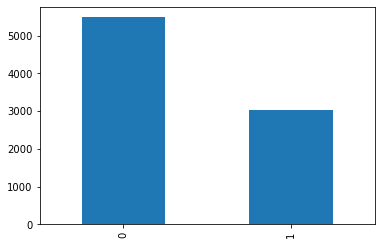

In [9]:
train["label"].value_counts().plot(kind="bar")

Blancing train set - to prevent biased model and poor performance.
We'll use oversampling for that.

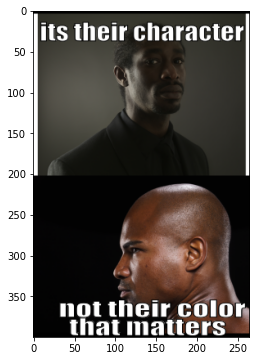

In [10]:
plt.figure(figsize=(10,6))
img = plt.imread(f"/kaggle/input/hate-memes/hateful_memes/img/42953.png")
plt.imshow(img)

In [11]:
images = [
    Image.open(f"/kaggle/input/hate-memes/hateful_memes/{train.img[i]}").convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(265, 400)
(800, 533)
(558, 800)
(693, 800)
(550, 416)


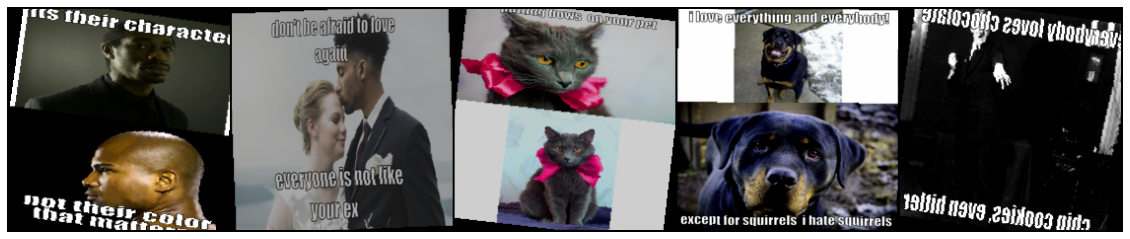

In [12]:
# define a callable image_transform with data augmentation
image_transform = transforms.Compose(
    [
        # we'll need to resize the images to form tensor 
        # minibatches appropriate for training a model.
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [13]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):

        self.samples_frame = pd.read_json(
            data_path, lines=True
        )
        self.dev_limit = dev_limit
        if balance:
            neg = self.samples_frame[
                self.samples_frame.label.eq(0)
            ]
            pos = self.samples_frame[
                self.samples_frame.label.eq(1)
            ]
            self.samples_frame = pd.concat(
                [
                    neg.sample(
                        pos.shape[0], 
                        random_state=random_state
                    ), 
                    pos
                ]
            )
        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.img = self.samples_frame.apply(
            lambda row: (img_dir / row.img), axis=1
        )

        # https://github.com/drivendataorg/pandas-path
        if not self.samples_frame.img.apply(lambda x: (img_dir / x).exists()).all():
            raise FileNotFoundError
        if not (self.samples_frame.img.apply(lambda x: (img_dir / x).is_file())).all():
            raise TypeError
            
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")
        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.encode_plus(
                self.samples_frame.loc[idx, "text"],
                add_special_tokens=True,
                max_length=512,
                pad_to_max_length=True,
            )["input_ids"]
        ).long().squeeze()
        

        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

In [14]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        post_language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_mid_size,
        fusion_output_size,
        dropout_p,
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.post_language_module = post_language_module
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=language_feature_dim + vision_feature_dim,
                out_features=fusion_mid_size
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=fusion_mid_size,
                out_features=fusion_output_size
            )
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text)[0][:, 0, :]
        )
        text_features = self.post_language_module(text_features)
        image_features = torch.nn.functional.relu(
            self.vision_module(image)   
        )
        combined = torch.cat(
            [text_features.squeeze(), image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

In [15]:
import pytorch_lightning as pl

# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super(HatefulMemesModel, self).__init__()
        self.hparams = hparams
        
        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get(
            "language_feature_dim", 300
        )
        self.vision_feature_dim = self.hparams.get(
            # balance language and vision features by default
            "vision_feature_dim", self.language_feature_dim
        )
        self.output_path = Path(
            self.hparams.get("output_path", "model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset("train_path")
        self.dev_dataset = self._build_dataset("dev_path")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        # Use mixed precision training to leverage hardware 
        # acceleration through mixed precision computations.
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"batch_val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }

    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        ]
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0]
            )
        ]
        return optimizers, schedulers
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.dev_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
        
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _build_text_transform(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                training_data = [
                    json.loads(line)["text"] + "/n" 
                    for line in open(
                        self.hparams.get("train_path")
                    ).read().splitlines()
                ]
                for line in training_data:
                    ft.write(line + "\n")
        ### using the tokenizer ###
                text_transform = getTokenizer()
        return text_transform

        ### using FastText embedding ###
        #         text_transform = fasttext.train_unsupervised(
        #             str(ft_path),
        #             model=self.hparams.get("fasttext_model", "cbow"),
        #             dim=self.embedding_dim
        #         )
        # return text_transform
        
    
    def _build_image_transform(self):
        image_dim = self.hparams.get("image_dim", 224)
        # Define the transformations for data augmentation
        image_transform = transforms.Compose(
        [
        # we'll need to resize the images to form tensor 
        # minibatches appropriate for training a model.
        transforms.Resize(size=(image_dim, image_dim)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor()
    ]
)
        return image_transform

    def _build_dataset(self, dataset_key):
        return HatefulMemesDataset(
            data_path=self.hparams.get(dataset_key, dataset_key),
            img_dir=self.hparams.get("img_dir"),
            image_transform=self.image_transform,
            text_transform=self.text_transform,
            # limit training samples only
            dev_limit=(
                self.hparams.get("dev_limit", None) 
                if "train" in str(dataset_key) else None
            ),
            balance=True if "train" in str(dataset_key) else False,
        )
    
    def _build_model(self):
        # configure roberta model
        #configuration = AutoConfig.from_pretrained(
            # dropout
            #hidden_dropout_prob=self.hparams.get("bert_hidden_dropout_p", 0.05),
            #attention_probs_dropout_prob=self.hparams.get("bert_attn_dropout_p", 0.05),
            
        #) 
        # load pretrained roberta
        language_module = gettextmodel()
        
        # we want to fine-tune the language module
        for param in language_module.parameters():
            param.requires_grad = True

        # the out of language_module will be the input of FC layer
        language_module.pooler = torch.nn.Linear(
            in_features=768, # bert hidden size
            out_features=self.language_feature_dim
        )
        
        vision_module = torchvision.models.densenet201(pretrained=True)
        
        vision_module.classifier = torch.nn.Linear(
                in_features=1920,
                out_features=self.vision_feature_dim
        )


        # load pretrained resnet152
        #vision_module = torchvision.models.resnet152(
        #    pretrained=True
        #)
        #vision_module.fc = torch.nn.Linear(
        #        in_features=2048,
        #        out_features=self.vision_feature_dim
        #)

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module, # the output of language_module is a tuple where the first value is the last_hidden_state
            post_language_module=language_module.pooler,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_mid_size=self.hparams.get("fusion_mid_size", 1024),
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            filepath=self.output_path,
            monitor=self.hparams.get(
                "checkpoint_monitor", "avg_val_loss"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "avg_val_loss"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 3
            ),
            verbose=self.hparams.get("verbose", True),
        )

        trainer_params = {
            "checkpoint_callback": checkpoint_callback,
            "early_stop_callback": early_stop_callback,
            "default_root_dir": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
            
    @torch.no_grad()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset.samples_frame.id,
            columns=["proba", "label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame
    
    
"""
the architecture of the model:
    # 1. text_transform: FastText num of parameters: 0 because we use the pretrained model without fine-tuning
    2. image_transform: ResNet152 num of parameters: 58,279,234
    3. language_module: Linear(in_features=300, out_features=512, bias=True) num of parameters: 153,600
    4. vision_module: Linear(in_features=2048, out_features=512, bias=True) num of parameters: 1,049,088
    5. fusion: Linear(in_features=1024, out_features=512, bias=True) num of parameters: 524,800
    6. output: Linear(in_features=512, out_features=2, bias=True) num of parameters: 1,026
    total num of parameters: 59,007,748
"""



'\nthe architecture of the model:\n    # 1. text_transform: FastText num of parameters: 0 because we use the pretrained model without fine-tuning\n    2. image_transform: ResNet152 num of parameters: 58,279,234\n    3. language_module: Linear(in_features=300, out_features=512, bias=True) num of parameters: 153,600\n    4. vision_module: Linear(in_features=2048, out_features=512, bias=True) num of parameters: 1,049,088\n    5. fusion: Linear(in_features=1024, out_features=512, bias=True) num of parameters: 524,800\n    6. output: Linear(in_features=512, out_features=2, bias=True) num of parameters: 1,026\n    total num of parameters: 59,007,748\n'

In [16]:
hparams = {
    
    # Required hparams
    "train_path": train_path,
    "dev_path": dev_path,
    "img_dir": data_dir,
    
    # Optional hparams
    "embedding_dim": 150,
    "language_feature_dim": 300,
    "vision_feature_dim": 300,
    "fusion_mid_size": 256, 
    "fusion_output_size": 256,
    "output_path": "model-outputs",
    "dev_limit": None,
    "lr": 0.00005,
    "max_epochs": 4,
    "n_gpu": 1, # torch.cuda.device_count(),
    "batch_size": 8,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 2, 
    "early_stop_patience": 3,
    "bert_hidden_dropout_p": 0.05,
    "bert_attn_dropout_p": 0.05
}

#hateful_memes_model = HatefulMemesModel(hparams=hparams)
#hateful_memes_model.(fit)()


In [ ]:
# use optuna to tune hyperparameters
# define objective function
def objective(trial):
    # sample hpsearch params
    hparams["lr"] = trial.suggest_float("lr", 1e-5, 2e-3, log=True)
    #hparams["dropout_p"] = trial.suggest_float("dropout_p", 0, 0.5, step=0.01)
    #hparams["bert_hidden_dropout_p"] = trial.suggest_float("bert_hidden_dropout_p", 0, 0.5, step=0.01)
    #hparams["bert_attn_dropout_p"] = trial.suggest_float("bert_attn_dropout_p", 0, 0.5, step=0.01)
    #hparams["accumulate_grad_batches"] = trial.suggest_categorical(
    #    "accumulate_grad_batches", [1, 2, 4, 8, 16, 32]
    #)
    #hparams["batch_size"] = trial.suggest_categorical(
    #    "batch_size", [4, 8, 16, 32, 64]
    #)
    #hparams["language_feature_dim"] = trial.suggest_int(
    #    "language_feature_dim", 100, 500, step=10
    #)
    #hparams["vision_feature_dim"] = trial.suggest_int(
    #    "vision_feature_dim", 100, 500, step=10
    #)
    #hparams["fusion_output_size"] = trial.suggest_int(
    #    "fusion_output_size", 100, 500, step=10
    #)
    print("lr = ", hparams["lr"])

    # train model
    hateful_memes_model = HatefulMemesModel(hparams=hparams)
    hateful_memes_model.fit()
    
    # report results back to optuna
    return hateful_memes_model.trainer.callback_metrics["val_loss"].item()


# define optuna params
study = optuna.create_study(direction="minimize")

# optimize model
study.optimize(objective, n_trials=30, timeout=3600, show_progress_bar=True)



lr =  0.00042457481349343363


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth


EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring avg_val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | LanguageAndVisionConcat | 85 M  


In [ ]:
# empty GPU memory
# torch.cuda.empty_cache()

In [ ]:
# we should only have saved the best checkpoint
checkpoints = list(Path("model-outputs").glob("*.ckpt"))
assert len(checkpoints) == 1

checkpoints

In [ ]:
hateful_memes_model = HatefulMemesModel.load_from_checkpoint(
    checkpoints[0].as_posix()
)
submission = hateful_memes_model.make_submission_frame(
    test_path
)
submission.head()

In [ ]:
submission.groupby("label").proba.mean()


In [ ]:
submission.label.value_counts()


In [ ]:
submission.to_csv(("model-outputs/submission.csv"), index=True)


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Assuming you have the submission frame with "proba" and "label" columns
proba = torch.tensor(submission['proba'].values)
label = torch.tensor(test['label'].values)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(label, proba)
print(f"AUC-ROC Score: {auc_roc}")

# Calculate accuracy
predictions = proba.round().long()
accuracy = accuracy_score(label, predictions)
print(f"Accuracy: {accuracy}")

OCR (Optical Character Recognition) 

In [ ]:
!pip install pytesseract

In [ ]:
import pytesseract

#image_path = "/kaggle/input/hate-memes/hateful_memes/img/42953.png"
#image_path = "/kaggle/input/hate-memes/hateful_memes/img/01236.png"
image_path = "/kaggle/input/hate-memes/hateful_memes/img/01243.png"

# Convert the image to grayscale
image = Image.open(image_path).convert("L")

image = image.filter(ImageFilter.MedianFilter())

text = pytesseract.image_to_string(image, lang='eng')

print(text)

In [ ]:
!pip install --upgrade easyocr
!pip install --upgrade opencv-python

In [ ]:
import easyocr
import cv2

reader = easyocr.Reader(['en'])

#image_path = "/kaggle/input/hate-memes/hateful_memes/img/42953.png"
#image_path = "/kaggle/input/hate-memes/hateful_memes/img/01236.png"
image_path = "/kaggle/input/hate-memes/hateful_memes/img/01243.png"

result = reader.readtext(image_path)

extracted_text = []
for detection in result:
    text = detection[1]
    # Perform post-processing to handle "o" and "0" confusion
    #text = text.replace('0', 'o')
    extracted_text.append(text)
    
for text in extracted_text:
    print(text)